# Analyse the Grid Search model fitting

In [1]:
import sys
sys.path.append('/mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject')

import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json
from scipy.interpolate import CubicSpline
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from typing import Iterable

from import_data import BailerJones
from model_functions import *
from functions import import_spectra, extract_spectrum_within_range

##### Some handy functions

In [2]:
def extract_vsini(vsini:str)->int:
    """
    Takes a string like 'vsini###'
    This function extracts the number

    Args:
        vsini (str): String like 'vsini###'

    Returns:
        int: The number in the string
    """
    return int(re.search(r'\d+$', vsini).group())


def object_name_to_save_name(input_string):
    # Replace every '-' with '_'
    modified_string = input_string.replace('-', '_')
    
    # Remove space before capital 'X'
    modified_string = modified_string.replace(' ', '')

    return modified_string

##### Import the data

In [3]:
# Define the path to the gridsearch_info.txt file
file_path = '/mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject/ModelFitting/FitResults/SMCX_1S100E250delta5/gridsearch_info.txt'
# Initialize variables to store extracted information
grid_search_info = {}

# Open the file and read its contents
with open(file_path, 'r') as file:
    scentences = file.readlines()

    # Iterate through each line in the file
    for line in scentences:
        # Split the line based on the tab character ('\t') or any other delimiter used
        parts = line.split('\t')

        # Extract information based on the structure of the file
        if parts[0] == 'Object: ':
            grid_search_info['Object'] = parts[2].strip()
            object_name = parts[2].strip()
        elif parts[0] == 'FolderPath: ':
            grid_search_info['FolderPath'] = parts[1].strip()
            folder_path = parts[1].strip()
        elif parts[0] == 'Galaxy: ':
            grid_search_info['Galaxy'] = parts[2].strip()
            galaxy = parts[2].strip()
        elif parts[0] == 'Radial Velocity: ':
            grid_search_info['vrad'] = parts[2].strip()
            vrad = round(float(parts[2].strip()), 3)
        elif parts[0] == 'Radial Velocity error: ':
            grid_search_info['vrad_err'] = parts[1].strip()
            vrad_err = round(float(parts[1].strip()), 3)
        # Add more conditions to extract other information as needed

# Change the object name to save name
object_ = object_name_to_save_name(object_name)

# Now, you have extracted information stored in the grid_search_info dictionary
# You can access it like this:
print("Object:", grid_search_info.get('Object', 'Not Found'))
print("Object_:", object_)
print("FolderPath:", grid_search_info.get('FolderPath', 'Not Found'))
print("Galaxy:", grid_search_info.get('Galaxy', 'Not Found'))
print("Radial velocity:", grid_search_info.get('vrad', 'Not Found'), ' km/s')
print("Radial velocity error:", grid_search_info.get('vrad_err', 'Not Found'), ' km/s') 
print(f'vrad = {vrad} +- {vrad_err} km/s')

Object: SMC X-1
Object_: SMCX_1
FolderPath: /mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject/ModelFitting/FitResults/SMCX_1S100E250delta5/
Galaxy: SMC
Radial velocity: 205.34896272541638  km/s
Radial velocity error: 15.944215376163775  km/s
vrad = 205.349 +- 15.944 km/s


In [4]:
# Load the JSON file
with open(folder_path + 'Chi2.json', 'r') as json_file:
    grid_result = json.load(json_file)

# Load the JSON file
with open(folder_path + 'Chi2_perline.json', 'r') as json_file:
    grid_result_perline = json.load(json_file)

- Take the minimun $\chi^{2}$ value for every value of vsin(i):  <strong> min_chi2_list </strong>
- Save every vsin(i): <strong> vsini_list </strong>
- For every vsin(i) save the name of the best model: <strong> best_models </strong>

In [5]:
vsini_list = []
min_chi2_list = []
best_models = []

for vsini, chi2 in grid_result.items():
    vsini_list.append(extract_vsini(vsini))
    min_chi2_list.append(chi2[min(chi2, key=chi2.get)])
    best_models.append(min(chi2, key=chi2.get))

##### First result

In [6]:
# Best vsin(i)
vsini_best = list(grid_result.keys())[min_chi2_list.index(min(min_chi2_list))]

# All chi2 values of the best vsin(i)
chi2_best = grid_result[vsini_best]

# Best model of the best vsin(i)
best_model = min(chi2_best, key=chi2_best.get)

print(f"The minimum chi-squared: \t {round(chi2_best[min(chi2_best, key=chi2_best.get)], 4)}")
print(f"The best vsin(i): \t\t {extract_vsini(vsini_best)} km/s")
print(f"This is for model: \t\t {best_model}")

The minimum chi-squared: 	 4.1155
The best vsin(i): 		 170 km/s
This is for model: 		 T28000logg3.0


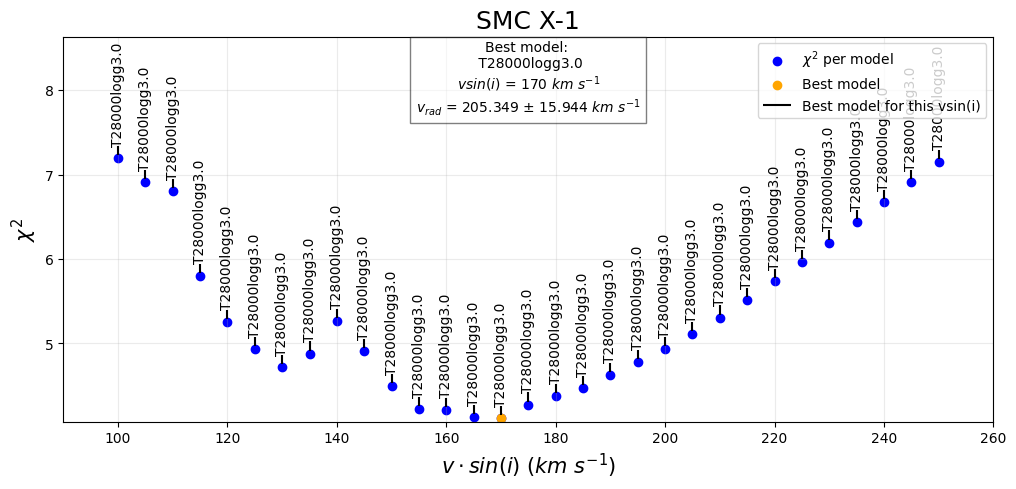

In [7]:
plt.figure(figsize=(12,5))
plt.scatter(vsini_list, min_chi2_list, color='blue', label=r'$\chi^{2}$ per model')
plt.scatter(extract_vsini(vsini_best), chi2_best[best_model], color='orange', label='Best model')

plt.text(0.5, 0.89, f'Best model: \n {best_model}\n' + r'$vsin(i)$ = ' + f'{extract_vsini(vsini_best)} ' + r'$km$ $s^{-1}$' + '\n' + 
         r'$v_{rad}$ = ' + f'{vrad}' + r' $\pm$ ' + f'{vrad_err}' + r' $km$ $s^{-1}$', 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Annotate each line with text vertically
plt.vlines(vsini_list, 
           ymin=np.array(min_chi2_list) + max(min_chi2_list) / 200, 
           ymax=np.array(min_chi2_list) + max(min_chi2_list) / 50, 
           color='black', label='Best model for this vsin(i)')

for (x, y, best_model_) in zip(vsini_list, min_chi2_list, best_models):
    plt.text(x, y + max(min_chi2_list) / 50, 
             f'{best_model_}', ha='center', va='bottom', rotation=90, size=10)

plt.title(f"{object_name}", fontsize=18)
plt.ylabel(r'$\chi^{2}$', fontsize=15)
plt.xlabel(r'$v \cdot sin(i)$ ($km$ $s^{-1}$)', fontsize=15)

plt.xlim(min(vsini_list) - 10, max(vsini_list) + 10)
plt.ylim(min(min_chi2_list) * 0.99, max(min_chi2_list) * 1.2)

plt.grid(alpha=0.25)
plt.legend(loc='best')

# plt.savefig("../Plots/GridSearchAnalysisCenX_3.png")

plt.show()

##### How does the $\chi^{2}$ distribution look for just the best model

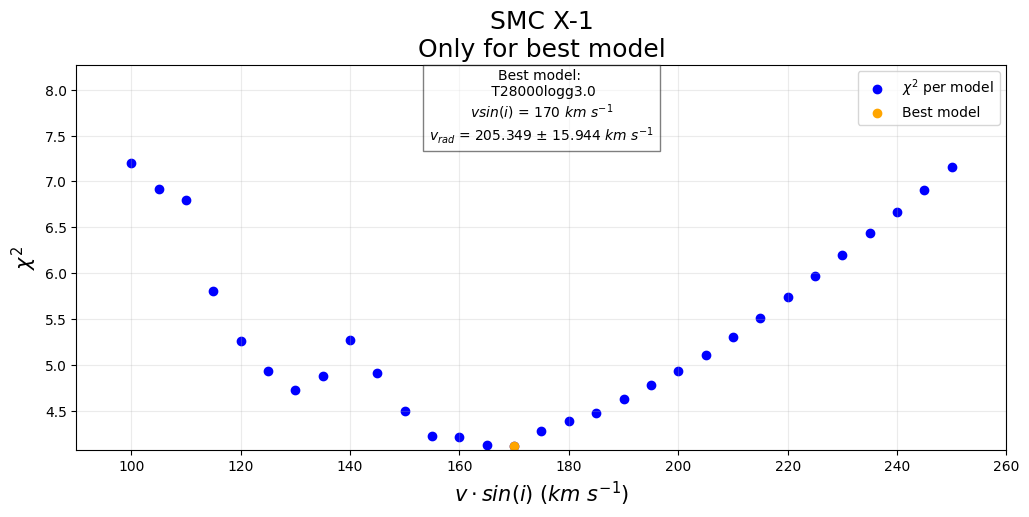

In [8]:
vsini_list_best = []
min_chi2_list_best = []

for vsini, chi2 in grid_result.items():
    vsini_list_best.append(extract_vsini(vsini))
    min_chi2_list_best.append(chi2[best_model])

plt.figure(figsize=(12,5))
plt.scatter(vsini_list_best, min_chi2_list_best, color='blue', label=r'$\chi^{2}$ per model')
plt.scatter(extract_vsini(vsini_best), chi2_best[best_model], color='orange', label='Best model')

plt.text(0.5, 0.89, f'Best model: \n {best_model}\n' + r'$vsin(i)$ = ' + f'{extract_vsini(vsini_best)} ' + r'$km$ $s^{-1}$' + '\n' + 
         r'$v_{rad}$ = ' + f'{vrad}' + r' $\pm$ ' + f'{vrad_err}' + r' $km$ $s^{-1}$',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.title(f"{object_name}\nOnly for best model" , fontsize=18)
plt.ylabel(r'$\chi^{2}$', fontsize=15)
plt.xlabel(r'$v \cdot sin(i)$ ($km$ $s^{-1}$)', fontsize=15)

plt.xlim(min(vsini_list) - 10, max(vsini_list) + 10)
plt.ylim(min(min_chi2_list) * 0.99, max(min_chi2_list) * 1.15)

plt.grid(alpha=0.25)
plt.legend(loc='best')

# plt.savefig("../Plots/GridSearchAnalysisCenX_3.png")

plt.show()

##### Plot the best model of the spectral lines

In [9]:
%matplotlib qt

In [10]:
spectra = import_spectra(object_)
models = import_models_quickload(galaxy)
spectral_lines = lines(object_name)

plot_best_model(spectra, models, spectral_lines, best_model, vrad, extract_vsini(vsini_best))